# Class 23: Linear regression and unsupervised learning

Plan for today:
- Linear regression
- Clustering


In [2]:
import YData

# YData.download.download_class_code(23)   # get class code    
# YData.download.download_class_code(23, TRUE) # get the code with the answers 

# YData.download.download_homework(9)  # downloads the homework 

# project review template
# YData.download.download_class_file('reviewer_template.ipynb', 'homework')


If you are using colabs, you should run the code below.

In [ ]:
# !pip install https://github.com/lederman/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

# Suppress ConvergenceWarning - please ignore this code 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## 1. Linear regression

In regression, we try to predict a quantitative variable y, from a set of features X. 

Let's explore this by predicting the body mass of penguins (in grams) from other quantitative features of a penguin (e.g., their bill and flipper sizes). 


In [5]:
penguins = sns.load_dataset("penguins")

penguins = penguins.dropna()

penguins = penguins.sample(frac = 1)

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
312,Gentoo,Biscoe,45.5,14.5,212.0,4750.0,Female
256,Gentoo,Biscoe,42.6,13.7,213.0,4950.0,Female
268,Gentoo,Biscoe,44.9,13.3,213.0,5100.0,Female
231,Gentoo,Biscoe,49.0,16.1,216.0,5550.0,Male
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female


In [6]:
# get the features and the labels

X_penguin_features = penguins[['bill_length_mm', 
                               'bill_depth_mm',
                               'flipper_length_mm']]

y_penguin = penguins['body_mass_g']


# also save the penguin species to use later
y_penguin_species = penguins['species']


Let's use scikit-learn to generate training and test data as we did previously for our KNN classifier. 

In [7]:
from sklearn.model_selection import train_test_split

# split data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(X_penguin_features,  
                                                    y_penguin, 
                                                    random_state = 0)

print(X_train.shape)
print(X_test.shape)

X_train.head(5)


(249, 3)
(84, 3)


,bill_length_mm,bill_depth_mm,flipper_length_mm
23,38.2,18.1,185.0
148,36.0,17.8,195.0
341,50.4,15.7,222.0
209,49.3,19.9,203.0
60,35.7,16.9,185.0


We can now create a new linear regression model, fit it to data, and make predictions. The method names are again very similar to what we used for the KNN classifier (i.e., the `fit()` and predict()` methods). 

In [8]:
from sklearn.linear_model import LinearRegression

# create a new linear regression modedl
linear_model = LinearRegression()

In [9]:
# fit the model to our training data

linear_model.fit(X_train, y_train)

LinearRegression()

In [10]:
# make predictions of the penguins body weight on the test data

body_mass_predictions = linear_model.predict(X_test)
body_mass_predictions[0:5]

array([4902.22129654, 3653.12738489, 3960.18968301, 5325.0343656 ,
       3663.00141986])

We can assess the accuracy of our predictons using the root mean squared error which is defined as: 

$$RMSE = \sqrt{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

Here $\hat{y}$ is the predictions made by our linear model on the test data (i.e., the predicted body weight) and y is the actual body weights for the points in our test set.

In [11]:
# test the RMSE on the test data

RMSE = np.sqrt(np.mean((y_test - body_mass_predictions)**2))

RMSE   # shows (in grams) how for our predictions of penguin mass is typically off by


366.6056891355985

We can also use scikit-learn's `mean_squared_error()` to get the MSE, and we can use the `cross_val_score` to run k-fold cross-validation (again, in a very similar way to what we did for our KNN classifier). 

In [12]:
from sklearn.metrics import mean_squared_error

# Use scikit-learn's mean_squared_error() function to get the RMSE
np.sqrt(mean_squared_error(y_test, body_mass_predictions))


366.6056891355985

In [13]:
# using cross-validation
from sklearn.model_selection import cross_val_score

linear_model = LinearRegression()

scores = cross_val_score(linear_model, 
                         X_penguin_features,  
                         y_penguin, 
                         cv = 5, 
                         scoring='neg_mean_squared_error')

np.sqrt(np.mean(-1 * scores))

394.93625871557174

### Regression model equation

In linear regression, our predicted $\hat{y}$ values are given by the equation: $\hat{y} = b_0 + b_1 x_1 + ... + + b_k x_k$.

Let's fill out this equation for prediciting penguin body mass. 

To do this, let's start by extracting the intercept ($b_0$) and slope coefficients ($b_i's$) from our scikit-learn model.


In [105]:

# fit the linear regression model to our training data
linear_model.fit(X_train, y_train)

# get the intercept and slope coefficients
sklearn_intercept = linear_model.intercept_
sklearn_coefficients = linear_model.coef_

# print out the coefficient values
(sklearn_intercept, sklearn_coefficients)  


(-6680.136818911194, array([ 0.50487641, 21.63844259, 52.14116732]))

Given these coefficient values can you write our the regression equation for predicting penguin body mass? 


#### Answer

$\hat{y}_{mass} = -6680.13 + 0.5049 \cdot x_{bill-length} + 21.6384 \cdot x_{bill-depth} +  52.1411 \cdot x_{lipper-length}$



#### Writing our own prediction function

Let's also write our own function called `get_predictions(b0_intercept, b_coefficients, X_data)` that takes the coefficient values and X values and returns predicted $\hat{y}$ values for each X value. In particular, the arguments to the function are:

1. `b0_intercept`: The linear regression intercept
2. `b_coefficients`: The linear regression slope coefficients
3. `X_data`: The X data values 

The returned value is a numpy ndarray of predictions for each X data point. 


In [106]:
# write a function to get the predictions
def get_predictions(b0_intercept, b_coefficients, X_data):
    return np.sum(X_data.to_numpy() * b_coefficients, axis = 1) + b0_intercept 


# get the predicted values on the test data
predicted_vals = get_predictions(sklearn_intercept, sklearn_coefficients, X_test)


# see the it matches the scikit-learn predictions
predicted_vals_sklearn = linear_model.predict(X_test)
predicted_vals == predicted_vals_sklearn


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

## Inference on regression coefficients

We can also run inference procedures on our regression model using the statsmodel package. In particular, we can run hypothesis tests and create confidence intervals for our regression coefficents. 

When running a hypothesis test, our hypotheses are:

$H_0: \beta_i = 0$  
$H_A: \beta_i \ne 0$


In [15]:
# Hypothesis test on regression coeffients - which coefficients are statistically significantly different from zero? 
# (and confidence interval)

import statsmodels.api as sm

# add a constant value of 1 to our data
X_train_with_constant = sm.add_constant(X_train) 

# fit the linear regression model using the OLS function
sm_linear_model = sm.OLS(y_train, X_train_with_constant).fit()

# get information on the regression coefficients found
print(sm_linear_model.summary())


                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     256.0
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           3.33e-75
Time:                        20:32:42   Log-Likelihood:                -1844.6
No. Observations:                 249   AIC:                             3697.
Df Residuals:                     245   BIC:                             3711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6680.1368    669.06

## 2. Unsupervised learning: clustering

We can do k-means clustering in scikit-learn using the `KMeans()` object.


In [14]:
from sklearn.cluster import KMeans

# fit k-means with 3 clusters 

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_penguin_features)

KMeans(n_clusters=3)

In [15]:
# see which cluster each point belongs to 

predicted_labels = kmeans.predict(X_penguin_features)
predicted_labels

array([2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1,
       1, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 2,
       2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1,
       0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 2,
       2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1,
       1, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 1, 0,
       0, 1, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 0, 2,
       2, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 1, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 2,
       2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0,
       2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1,

In [16]:
# look at a matrix of which penguin types end up in which cluster 

matrix = pd.DataFrame({'labels': predicted_labels, 
                       'species': y_penguin_species})

ct = pd.crosstab(matrix['labels'], matrix['species'])
print(ct)

species  Adelie  Chinstrap  Gentoo
labels                            
0           106          9       0
1             2          5     118
2            38         54       1


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# do clustering with feature normalization 
scaler = StandardScaler()
pipeline = make_pipeline(scaler, kmeans)

pipeline.fit(X_penguin_features)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3))])

In [18]:
# see which cluster each (normalized) point belongs to

predicted_labels2 = pipeline.predict(X_penguin_features)

predicted_labels2


array([1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0,
       0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 2,
       2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2,
       2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2, 0, 2, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1,
       1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 1, 2,
       2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 1,
       2, 1, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 1, 1, 0,

In [19]:
# look at a matrix of which penguin types end up in which cluster 

matrix_new = pd.DataFrame({'labels': predicted_labels2, 
                           'species': y_penguin_species})

ct_new = pd.crosstab(matrix_new['labels'], 
                     matrix_new['species'])
print(ct_new)

species  Adelie  Chinstrap  Gentoo
labels                            
0             0          0     119
1           141          5       0
2             5         63       0


### 2b. Unsupervised learning: Hierarchical clustering


In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

#  Ward's method adds points to a cluster that minimizes the sum of squared differences within all clusters
clusters = hierarchy.linkage(X_penguin_features, method="ward")   


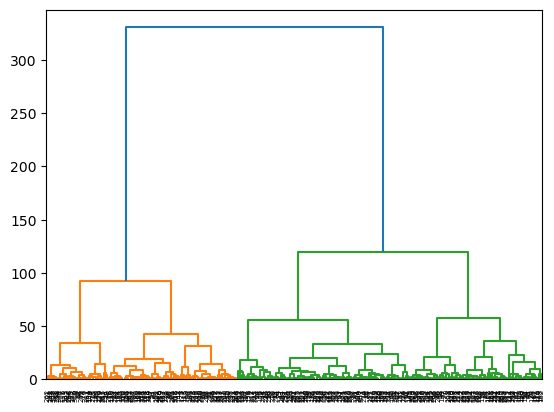

In [21]:
# display a dendrogram
dendrogram = hierarchy.dendrogram(clusters)

In [22]:
# cluster points into 3 clusters 
clustering_model = AgglomerativeClustering(n_clusters=3, linkage="ward")
clustering_model.fit(X_penguin_features)

# get the predicted cluster for each point
labels = clustering_model.labels_

labels

array([1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0,
       0, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0, 2, 0, 1,
       1, 0, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1,
       1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1,
       1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 0,
       0, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 1, 0, 2,
       2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1,
       1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 2,
       2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 2, 2,
       1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 2, 2, 2, 0,

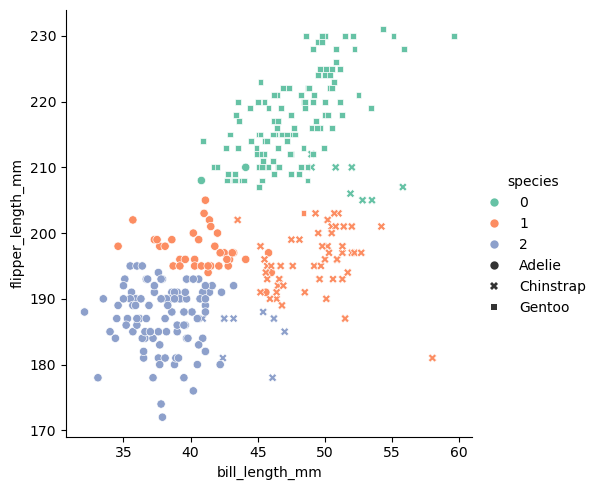

In [23]:
# visualize how well the clustering matches the penguin species

sns.relplot(X_penguin_features, 
            x='bill_length_mm', 
            y='flipper_length_mm', 
            hue=labels, 
            style = y_penguin_species,
            palette="Set2");
